[1.1749939972743841, -1.039810713263122 - 0.7006580731281623*I, -1.039810713263122 + 0.7006580731281623*I, 0.05338777414286551 - 0.7473087446575949*I, 0.05338777414286551 + 0.7473087446575949*I]


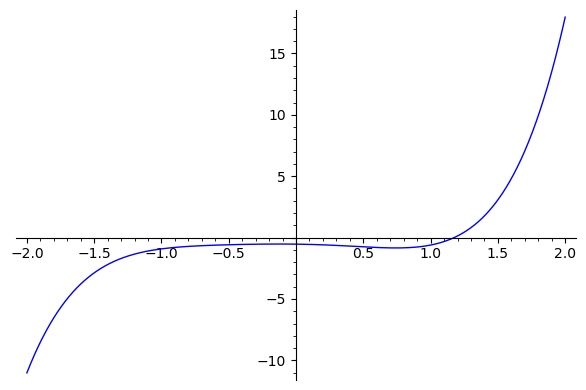

In [5]:
P.<x> = RDF[]
p = P.random_element(5)
print(p.roots(ring=CDF, multiplicities=False))
plot(p, -2, 2)

In [3]:
def test_solve(func, poly, margin=1e-15, ring=RDF):
    try:
        sol = func(poly, ring)
    except(ValueError):
        return (True, 0)
    for ans in sol:
        a = abs(poly(ans))
        if a > margin:
            return (False, ans)
    return (True, -1)

def multitest_solve(func, degree=5, samples=10000, margin=1e-15):
    #P.<x> = RDF[]
    P.<x> = RealField(100)[]
    errors = 0
    skipped = 0
    for i in range(samples):
        p = P.random_element(degree)
        (res, err) = test_solve(func, p, margin, RealField(100))
        if res == False:
            errors += 1
        if res == True and err == 0:
            skipped += 1
    print("Ran ", samples - skipped, " tests for polynomials of degree ", degree, "(", skipped, " skipped); ", errors, " solutions outside of margin ", margin)

# Solve using companion matrix

In [1]:
def monicize(poly, ring=RDF):
    tring.<x> = ring[]
    c = (poly / poly.coefficients()[-1]).coefficients()
    c[-1] = ring(1)
    return tring(c)

def companion_solve(poly, ring=RDF):
    mat = companion_matrix(monicize(poly, ring))
    solutions = mat.eigenvalues()
    return solutions

In [13]:
func = companion_solve
multitest_solve(func, 2)
multitest_solve(func, 3)
multitest_solve(func, 4)
multitest_solve(func, 5)
multitest_solve(func, 6)
multitest_solve(func, 7)
multitest_solve(func, 8)
multitest_solve(func, 9)
multitest_solve(func, 10)

<ipython-input-12-93578fbd482f>:9: UserWarning: Using generic algorithm for an inexact ring, which will probably give incorrect results due to numerical precision issues.
  solutions = mat.eigenvalues()


Ran  10000  tests for polynomials of degree  2 ( 0  skipped);  0  solutions outside of margin  1.00000000000000e-15
Ran  10000  tests for polynomials of degree  3 ( 0  skipped);  0  solutions outside of margin  1.00000000000000e-15
Ran  10000  tests for polynomials of degree  4 ( 0  skipped);  0  solutions outside of margin  1.00000000000000e-15
Ran  10000  tests for polynomials of degree  5 ( 0  skipped);  0  solutions outside of margin  1.00000000000000e-15
Ran  10000  tests for polynomials of degree  6 ( 0  skipped);  5  solutions outside of margin  1.00000000000000e-15
Ran  10000  tests for polynomials of degree  7 ( 0  skipped);  18  solutions outside of margin  1.00000000000000e-15
Ran  10000  tests for polynomials of degree  8 ( 0  skipped);  32  solutions outside of margin  1.00000000000000e-15
Ran  10000  tests for polynomials of degree  9 ( 0  skipped);  69  solutions outside of margin  1.00000000000000e-15
Ran  10000  tests for polynomials of degree  10 ( 0  skipped);  95  s

# Solve using Durand-Kerner

In [2]:
def dk_solve(poly, guesses, datafile, ring=RDF, iterations=1000, eqmargin=1e-15):
    tosolve = monicize(poly, ring)
    prev = guesses
    results = guesses
    o = open(datafile, 'w')
    o.write(str(prev) + '\n')
    for _ in range(iterations):
        for (ind, val) in enumerate(prev):
            diff = tosolve(val)
            num = prod([ 1 if abs(val - elem) <= eqmargin else (val - elem) for elem in prev ])
            results[ind] = val - diff / num
        prev = results
        o.write(str(prev) + '\n')
    o.close()
    return results

def getdelta(val, sol):
    s1 = sorted(val)
    s2 = sorted(sol)
    return sum([ abs(s1[i] - s2[i]) for i in range(len(s1)) ])

def dk_conv(poly, guesses, solutions, ring=RDF, maxoffset = 1e-5, maxit=10000, verbose=False, eqmargin=1e-15):
    tosolve = monicize(poly, ring)
    prev = guesses
    results = [ 0 for val in guesses ]
    it = 0
    offset = getdelta(prev, solutions)
    while(offset > maxoffset and it < maxit):
        if(verbose):
            print("Iteration " + str(it) + " -> delta " + str(offset) + ", values: ", prev)
            
        for(ind, val) in enumerate(prev):
            diff = tosolve(val)
            num = prod([ 1 if abs(val - elem) <= eqmargin else (val - elem) for elem in prev ])
            results[ind] = val - diff / num
        prev = results
        it = it + 1
        offset = getdelta(prev, solutions)
        
        for val in prev:
            if val == +Infinity or val == -Infinity:
                print("One or more values are infinite: ", prev)
                return -Infinity
    print("Delta: ", offset, " - values ", results, "; solutions: ", solutions, "; guesses", guesses)
    return it

def get_conv(poly, sol, maxit=10000, ring=RDF, times=25, maxoffset=1e-5):
    diff = 0.01
    res = dict()
    res[0.0] = dk_conv(poly, sol, sol, ring, maxoffset, maxit)
    for _ in range(times):
        res[diff] = dk_conv(poly, [s + diff for s in sol], sol, ring, maxoffset, maxit)
        res[-diff] = dk_conv(poly, [s - diff for s in sol], sol, ring, maxoffset, maxit)
        diff = diff * 3
    return [ (str(k) + "," + str(v)) for k, v in res.items() ]

In [144]:
R.<x> = RDF[]
C.<x> = CDF[]

poly = R([ 0, -30, 14, 14, 2 ])
print([ 1, 0, -3, -5 ])
print(dk_solve(poly, [ 1.01, 0, -4.95, 0.05 ], '/home/jay/data1.dt'))

poly2 = R([ 0, 18, -12, 2 ])
print([ 0, 3, 3 ])
print(dk_solve(poly2, [ 0.05, 3.02, 2.95 ], '/home/jay/data2.dt'))

poly3 = C([ complex(-1, 3), complex(-3, -2), complex(1, 0) ])
print([ complex(0, 1), complex(3, 1) ])
print(dk_solve(poly3, [ complex(0.05, 0.95), complex(2.95, 1.05) ], '/home/jay/data3.dt', ring=CDF))

poly4 = C([ complex(-3, -6), complex(-5, 2), complex(-1, 0), complex(1, 0) ])
print([ complex(3, 0), complex(0, -1), complex(-2, 1) ])
print(dk_solve(poly4, [ complex(2.95, 0.05), complex(0.05, -0.95), complex(-2.05, 1.05) ], '/home/jay/data4.dt', ring=CDF))

poly5 = C([ complex(0,0), complex(0, -4), complex(2) ])
print([ complex(0,0), complex(0, 2) ])
print(dk_solve(poly5, [ complex(0.05, -0.95), complex(0.06, -2.06) ], '/home/jay/data5.dt', ring=CDF))

[1, 0, -3, -5]
[-2.92566849739465, -893.3724060428259, -4.99706577452209, 1.00002830822132]
[0, 3, 3]
[-999.985003686825, 3.00171952946227, 2.99819980104428]
[1j, (3+1j)]
[-1.241770704463247e-17 + 1.0*I, 3.0 + 1.0*I]
[(3+0j), -1j, (-2+1j)]
[3.0 + 1.1470314929087035e-17*I, 3.569780320661601e-17 - 1.0*I, -2.0 + 1.0*I]
[0j, 2j]
[0.012221425586948463 + 2.0139310969716084*I, -996.8311964179067 - 5.705160237434776*I]


In [4]:
R.<x> = RealField(100)[]
poly6 = R([ 4, -4, 1 ])
#print(dk_conv(poly6, [2.01, 1.99], [2,2]))
#print('\n'.join(get_conv(poly6, [2], maxit=10000)))
#dk_conv(poly6, [2.01], [2], verbose=True)

# 2x (x - 1) = 2x^2 - 2x (nulw 0, 1)
poly7 = R([ 0, -2, 2 ])
dk_solve(poly7, [0.06, 1.05], '/home/jay/data6.dt')

[-999.857963505816, 1.00004558378482]

In [5]:
R.<x> = RDF[]
R([ -1,1,1,-1,1,1,1,1,1,1,1,1,1,1,1,1 ]).roots(ring=CDF,multiplicities=False)

[-0.9999999999999968,
 -0.948751994863436,
 0.5826363152521024,
 -0.9620918338030318 - 0.582128813897095*I,
 -0.9620918338030318 + 0.582128813897095*I,
 -0.6022263246993278 - 0.9712081890768428*I,
 -0.6022263246993278 + 0.9712081890768428*I,
 -0.09797725912850641 - 1.1154611601910962*I,
 -0.09797725912850641 + 1.1154611601910962*I,
 0.3846518587981315 - 0.9731715694497886*I,
 0.3846518587981315 + 0.9731715694497886*I,
 0.6017781550745605 - 0.6810277283737336*I,
 0.6017781550745605 + 0.6810277283737336*I,
 0.8589232435638375 - 0.4778106987964646*I,
 0.8589232435638375 + 0.4778106987964646*I]